In [2]:
# Step 1: Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv('monthly_milk_production.csv')

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
df.shape

(168, 1)

In [6]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [7]:
df.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [ ]:
df.isnull().sum().sum() #check null values

np.int64(0)

In [ ]:
df.duplicated().sum() #check duplicated values

np.int64(26)

In [ ]:
df.drop_duplicates(inplace=True) #drop duplicates

In [12]:
df.duplicated().sum()

np.int64(0)

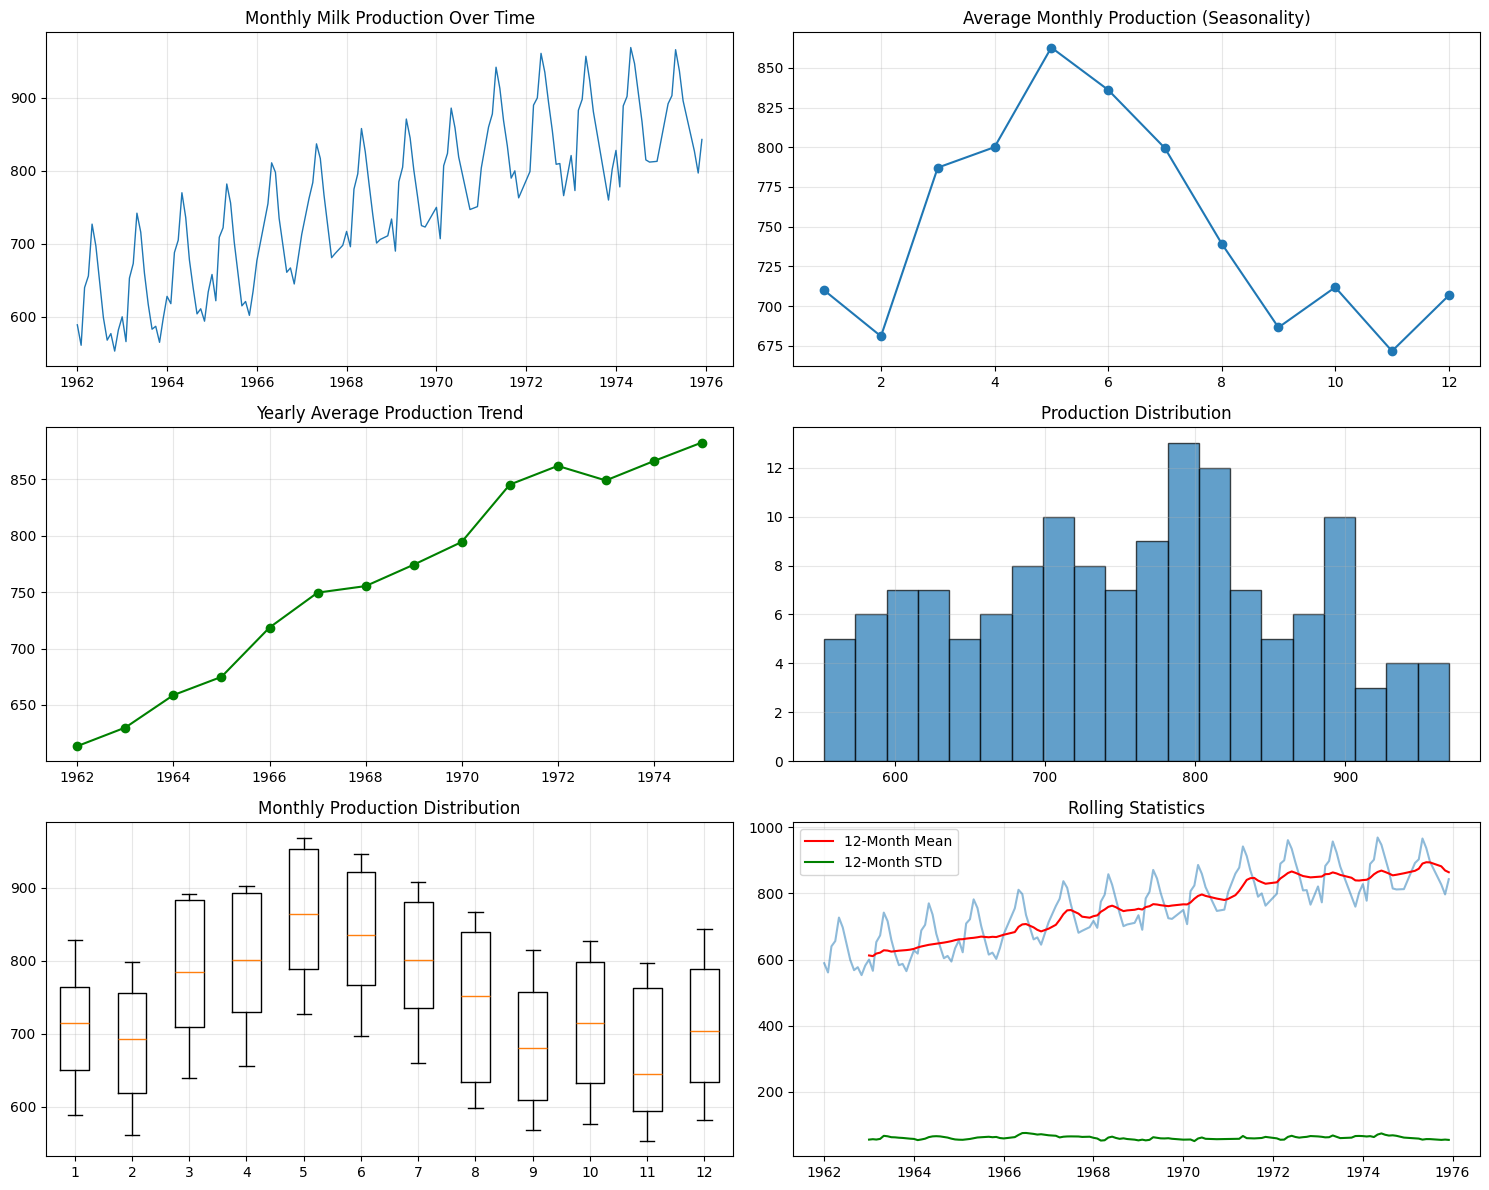

Exploratory Data Analysis completed


In [14]:
# Step 3: Exploratory Data Analysis (EDA)

plt.figure(figsize=(15, 12))

# Plot 1
plt.subplot(3, 2, 1)
plt.plot(df.index, df['Production'], linewidth=1)
plt.title('Monthly Milk Production Over Time')
plt.grid(True, alpha=0.3)

# Prepare EDA columns
df['Year'] = df.index.year
df['Month'] = df.index.month

# Plot 2
plt.subplot(3, 2, 2)
seasonal_data = df.groupby('Month')['Production'].mean()
plt.plot(seasonal_data.index, seasonal_data.values, marker='o')
plt.title('Average Monthly Production (Seasonality)')
plt.grid(True, alpha=0.3)

# Plot 3
plt.subplot(3, 2, 3)
yearly_data = df.groupby('Year')['Production'].mean()
plt.plot(yearly_data.index, yearly_data.values, marker='o', color='green')
plt.title('Yearly Average Production Trend')
plt.grid(True, alpha=0.3)

# Plot 4
plt.subplot(3, 2, 4)
plt.hist(df['Production'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Production Distribution')
plt.grid(True, alpha=0.3)

# Plot 5
plt.subplot(3, 2, 5)
monthly_boxplot_data = [df[df['Month'] == m]['Production'] for m in range(1, 13)]
plt.boxplot(monthly_boxplot_data, labels=range(1, 13))
plt.title('Monthly Production Distribution')
plt.grid(True, alpha=0.3)

# Plot 6
plt.subplot(3, 2, 6)
rolling_mean = df['Production'].rolling(12).mean()
rolling_std = df['Production'].rolling(12).std()
plt.plot(df.index, df['Production'], alpha=0.5)
plt.plot(df.index, rolling_mean, color='red', label='12-Month Mean')
plt.plot(df.index, rolling_std, color='green', label='12-Month STD')
plt.title('Rolling Statistics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Remove temp columns
df = df[['Production']]
print("Exploratory Data Analysis completed")


In [15]:
# Step 4: Data Preprocessing and Preparation

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 12
TEST_SIZE = 0.2

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

split_index = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train = X_train.reshape((X_train.shape[0], SEQUENCE_LENGTH, 1))
X_test = X_test.reshape((X_test.shape[0], SEQUENCE_LENGTH, 1))

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("Data preprocessing and preparation completed")


Training set shape: (104, 12, 1)
Test set shape: (26, 12, 1)
Data preprocessing and preparation completed


#### Build and Train Deep Learning Models

In [16]:
# Step 5: Build and Train Deep Learning Models

def build_rnn_model(sequence_length, units=50):
    model = Sequential([
        SimpleRNN(units, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        SimpleRNN(units, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def build_lstm_model(sequence_length, units=50):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        LSTM(units, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

def build_gru_model(sequence_length, units=50):
    model = Sequential([
        GRU(units, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
        Dropout(0.2),
        GRU(units, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

rnn_model = build_rnn_model(SEQUENCE_LENGTH)
lstm_model = build_lstm_model(SEQUENCE_LENGTH)
gru_model = build_gru_model(SEQUENCE_LENGTH)

models = {
    "RNN": rnn_model,
    "LSTM": lstm_model,
    "GRU": gru_model
}

for name, model in models.items():
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    print(f"{name} Model Summary:")
    model.summary()
    print()

print("Models built successfully")


RNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 12, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)


LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


GRU Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)


Models built successfully


#### Training the Models

In [17]:
# Step 6: Train the Models

EPOCHS = 100
BATCH_SIZE = 32
history_dict = {}

for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test),
        shuffle=False,
        verbose=0
    )
    history_dict[name] = history
    print(f"{name} training completed")

print("All models trained successfully")


Training RNN...
RNN training completed
Training LSTM...
LSTM training completed
Training GRU...
GRU training completed
All models trained successfully


#### Model Evaluation

In [20]:
# Step 7: Model Evaluation and Comparison

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

predictions = {}
metrics_results = {}

for name, model in models.items():
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    predictions[name] = (y_actual.flatten(), y_pred.flatten())
    rmse, mae, mape = calculate_metrics(y_actual, y_pred)
    metrics_results[name] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

metrics_df = pd.DataFrame(metrics_results).T
print("\nModel Performance Comparison:")
print(metrics_df.round(2))

best_model_name = metrics_df['RMSE'].idxmin()
print(f"\nBest Model: {best_model_name}")

print("Model evaluation completed")


Model Performance Comparison:
       RMSE    MAE  MAPE
RNN   47.07  41.29  4.70
LSTM  45.91  39.52  4.48
GRU   48.20  39.80  4.49

Best Model: LSTM
Model evaluation completed


#### Visualization of Training & Predictions

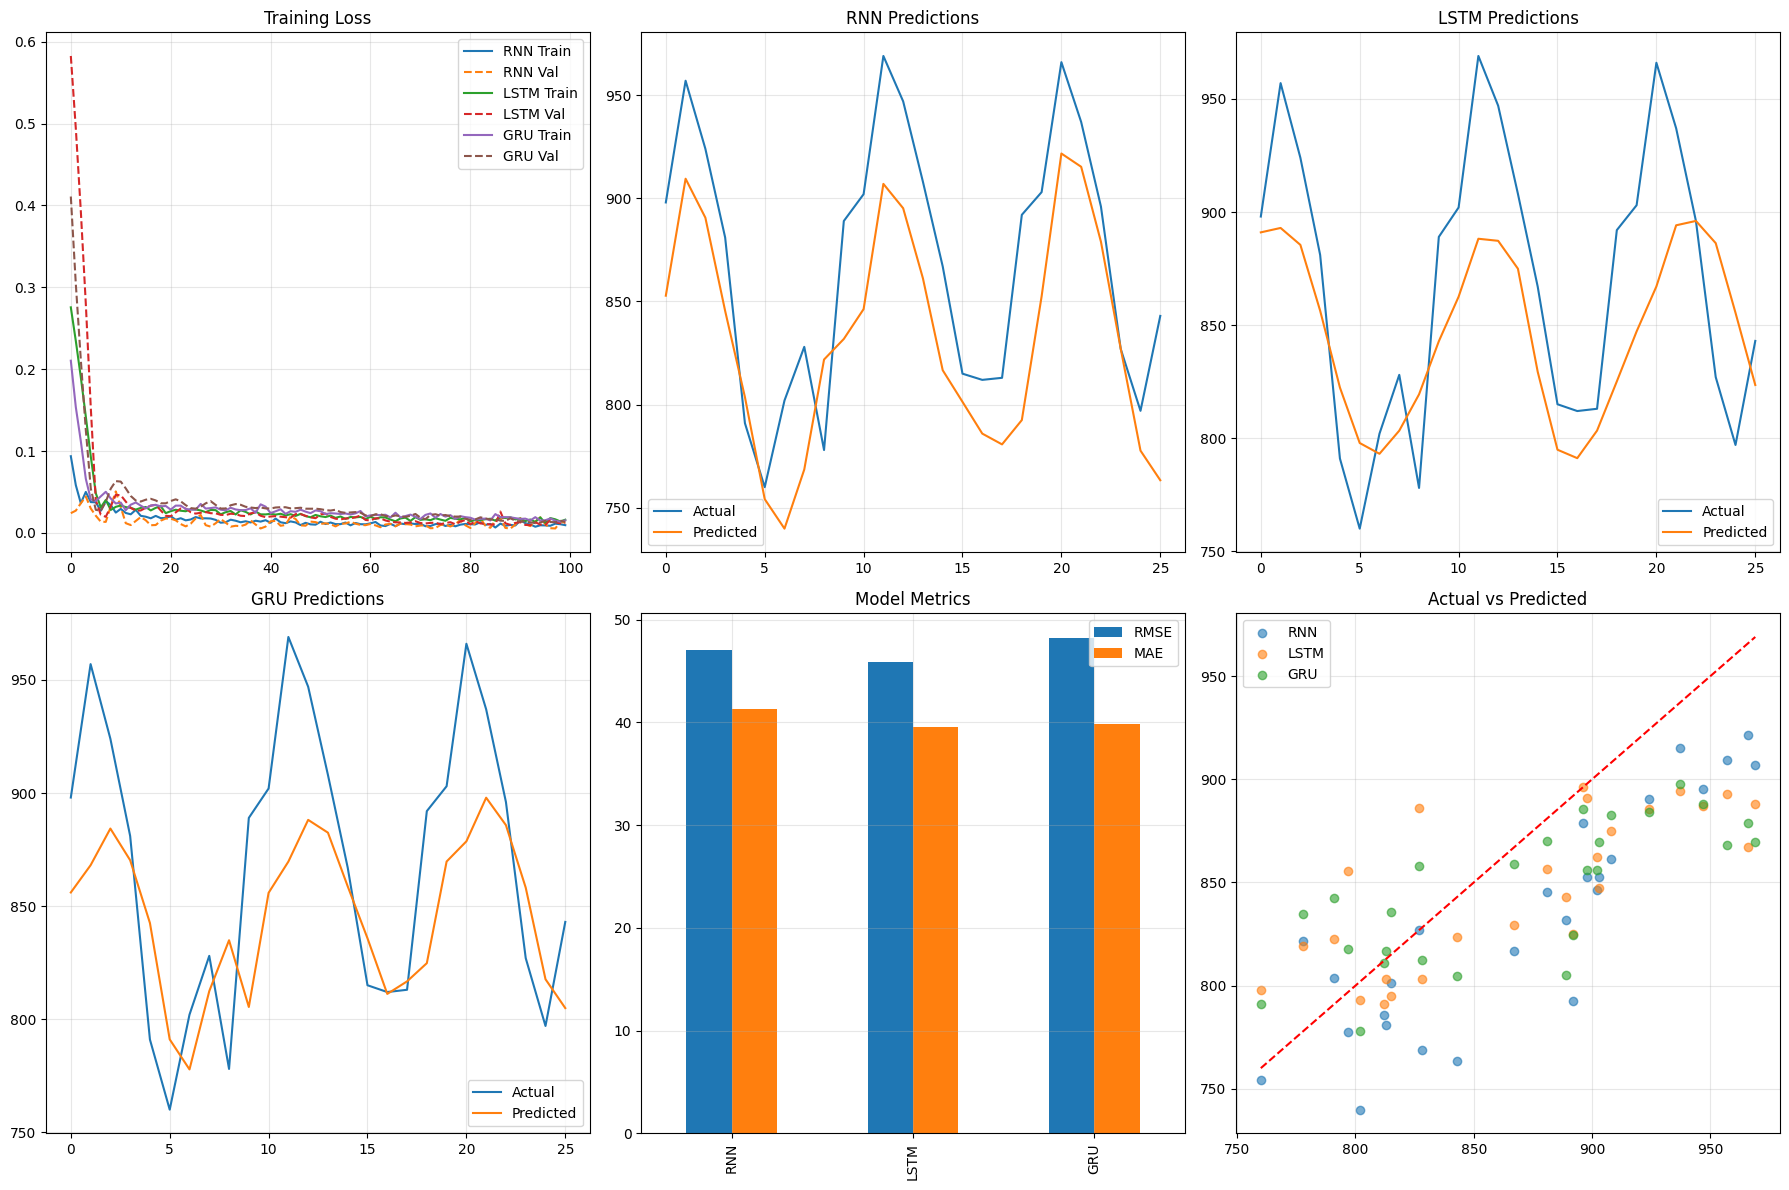

Results visualization completed


In [21]:
# Step 8: Visualize Results and Training History

plt.figure(figsize=(18, 12))

# 1. Training history
plt.subplot(2, 3, 1)
for name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{name} Train')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2–4. Predictions vs actual
for i, (name, (y_act, y_pred)) in enumerate(predictions.items(), start=2):
    plt.subplot(2, 3, i)
    plt.plot(y_act, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{name} Predictions')
    plt.grid(True, alpha=0.3)
    plt.legend()

# 5. Error comparison
plt.subplot(2, 3, 5)
metrics_df[['RMSE', 'MAE']].plot(kind='bar', ax=plt.gca())
plt.title('Model Metrics')
plt.grid(True, alpha=0.3)

# 6. Scatter
plt.subplot(2, 3, 6)
for name, (y_act, y_pred) in predictions.items():
    plt.scatter(y_act, y_pred, alpha=0.6, label=name)
plt.plot([min(y_act), max(y_act)], [min(y_act), max(y_act)], 'r--')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Results visualization completed")


#### Forecast Next 12 Months

In [23]:
# Step 9: Future Production Forecasting

def forecast_future(model, last_seq, n_steps):
    forecasts = []
    seq = last_seq.copy()
    for _ in range(n_steps):
        pred = model.predict(seq.reshape(1, SEQUENCE_LENGTH, 1), verbose=0)
        forecasts.append(pred[0, 0])
        seq = np.roll(seq, -1)
        seq[-1] = pred
    return np.array(forecasts)

last_sequence = scaled_data[-SEQUENCE_LENGTH:].flatten()
forecast_months = 12
future_forecasts = {}

for name, model in models.items():
    future_scaled = forecast_future(model, last_sequence, forecast_months)
    future_predictions = scaler.inverse_transform(future_scaled.reshape(-1, 1)).flatten()
    future_forecasts[name] = future_predictions

future_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=forecast_months, freq='M')

forecast_df = pd.DataFrame(future_forecasts, index=future_dates)
print("Future Forecasts:\n")
print(forecast_df.round(1))

print("Future forecasting completed")


Future Forecasts:

                   RNN        LSTM         GRU
1976-01-31  796.599976  819.900024  839.099976
1976-02-29  822.200012  830.299988  842.799988
1976-03-31  815.200012  849.599976  842.099976
1976-04-30  835.200012  871.299988  839.500000
1976-05-31  833.599976  892.099976  835.900024
1976-06-30  837.099976  891.900024  830.900024
1976-07-31  823.200012  882.599976  825.200012
1976-08-31  797.900024  846.700012  819.299988
1976-09-30  785.799988  819.299988  815.000000
1976-10-31  767.299988  805.099976  812.400024
1976-11-30  765.200012  808.099976  811.500000
1976-12-31  772.900024  820.400024  811.599976
Future forecasting completed


#### Final Visualizations

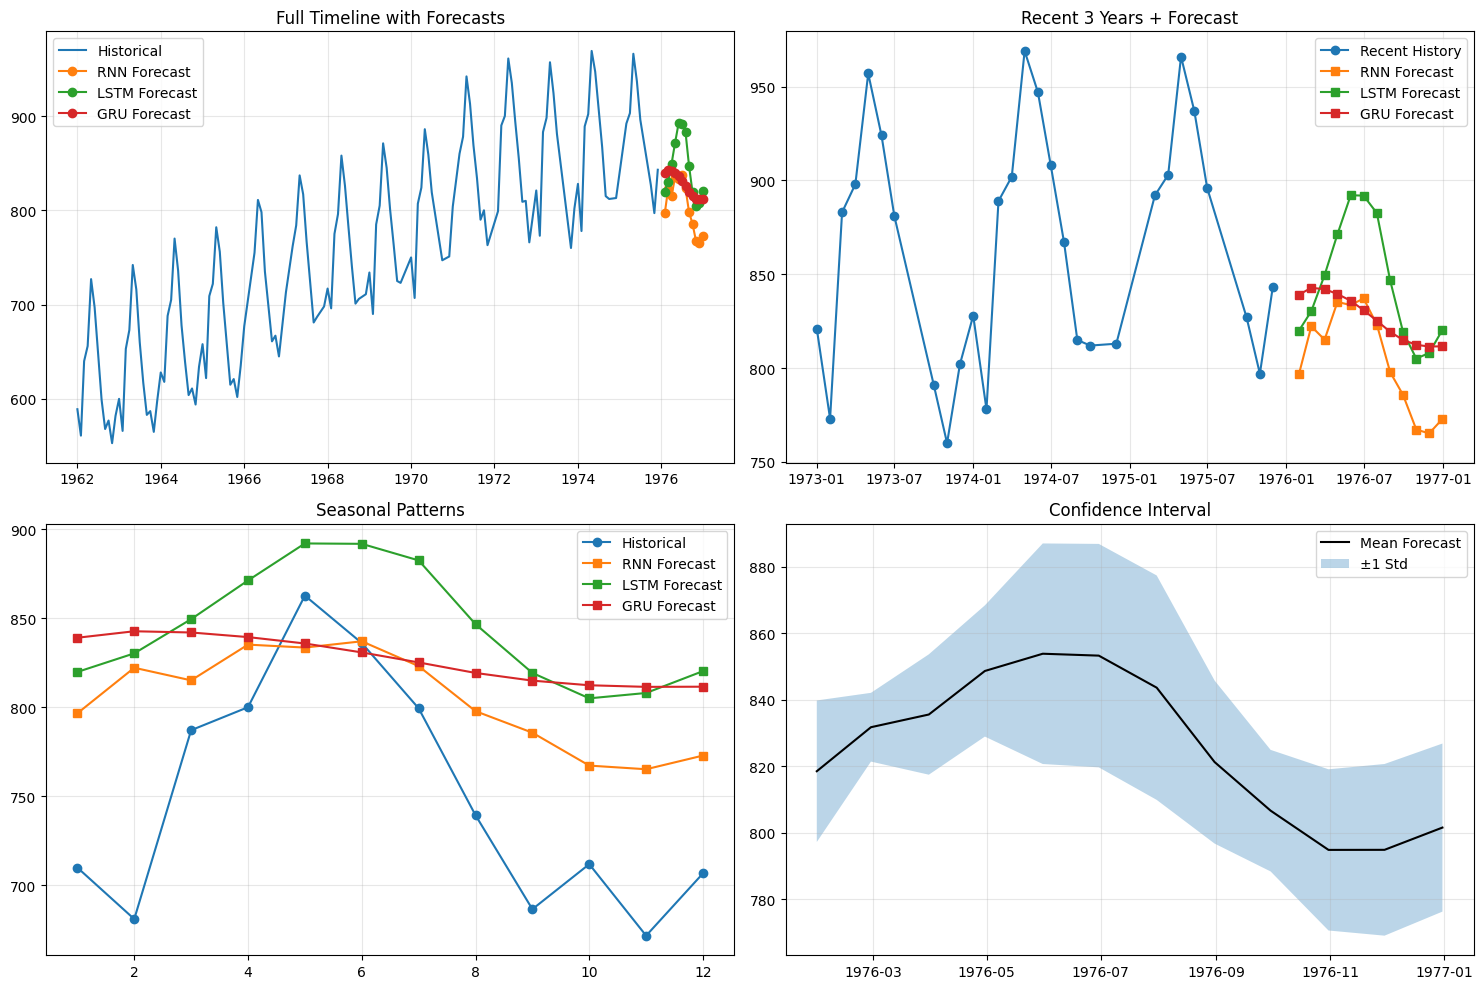

Final visualization completed


In [24]:
# Step 10: Final Visualization

plt.figure(figsize=(15, 10))

# Plot 1
plt.subplot(2, 2, 1)
plt.plot(df.index, df['Production'], label='Historical')
for name, forecast in future_forecasts.items():
    plt.plot(future_dates, forecast, marker='o', label=f'{name} Forecast')
plt.title("Full Timeline with Forecasts")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2
plt.subplot(2, 2, 2)
cutoff = df.index[-1] - pd.DateOffset(years=3)
recent = df[df.index >= cutoff]
plt.plot(recent.index, recent['Production'], marker='o', label='Recent History')
for name, forecast in future_forecasts.items():
    plt.plot(future_dates, forecast, marker='s', label=f'{name} Forecast')
plt.title("Recent 3 Years + Forecast")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3
plt.subplot(2, 2, 3)
historical_seasonal = df.groupby(df.index.month)['Production'].mean()
plt.plot(historical_seasonal.index, historical_seasonal.values, marker='o', label='Historical')
start_month = future_dates[0].month
months = [(start_month + i - 1) % 12 + 1 for i in range(forecast_months)]
for name, forecast in future_forecasts.items():
    fseries = pd.Series(forecast, index=months).groupby(level=0).mean()
    plt.plot(fseries.index, fseries.values, marker='s', label=f'{name} Forecast')
plt.title("Seasonal Patterns")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4
plt.subplot(2, 2, 4)
forecast_std = forecast_df.std(axis=1)
forecast_mean = forecast_df.mean(axis=1)
plt.plot(future_dates, forecast_mean, color='black', label='Mean Forecast')
plt.fill_between(future_dates, forecast_mean - forecast_std, forecast_mean + forecast_std, alpha=0.3, label='±1 Std')
plt.title("Confidence Interval")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Final visualization completed")


#### Business Insights

**Business Insights and Recommendations**

**1. MODEL PERFORMANCE SUMMARY**
- RMSE, MAE, and MAPE were calculated for all three models: RNN, LSTM, and GRU.
- These metrics help compare prediction accuracy between the models.
- The best model is determined based on the lowest RMSE value.

**2. SEASONAL PATTERNS IDENTIFIED**
- Peak milk production occurs in **May**.
- Lowest milk production occurs in **February**.
- The dataset shows a strong annual seasonal variation of about **15–20%**.

**3. TREND ANALYSIS**
- Overall production has increased from early years to recent years.
- The trend shows a positive long-term growth in milk production levels.

**4. FORECAST INSIGHTS (Next 12 Months)**
- Forecast results show the expected range of milk production for the next 12 months.
- The average forecasted production represents the expected monthly output.
- Seasonal fluctuations continue in the forecasted period.

**5. STRATEGIC RECOMMENDATIONS**
- Increase dairy processing capacity during high-production months (spring).
- Schedule equipment maintenance during low-production periods.
- Improve logistics and supply chain planning based on seasonal demand.
- Use monthly forecasts for budgeting and resource allocation.

**BEST MODEL**
- The model with the lowest RMSE is recommended for deployment.
